In [1]:
import torch
torch.__version__

'1.13.1+cu117'

In [2]:
import sys
sys.path.append('..')

In [3]:
from simulators import SLCP
from inference_utils import get_prior

dim_x = 8
n_sims = 1000
n_params = 5

prior = get_prior('SLCP')
theta = prior.sample((n_sims,))

X = torch.empty((n_sims,dim_x))
for i in range(n_sims):
    X[i] = SLCP(theta[i])
X

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  m = torch.stack(


tensor([[  3.2490,  -5.6882,   3.1629,  ...,  -3.9720,   4.5036,  -5.1198],
        [  5.1175,  -2.0648,  -1.2304,  ...,  -2.0296,   0.8775,  -1.9298],
        [  0.7011,   1.4570,   1.6045,  ...,   0.9849,   1.3942,   0.7421],
        ...,
        [  2.0314,   1.8749,   0.5099,  ...,   1.1527,   1.0531,   4.9094],
        [ -2.2511,   4.5324,  -7.1154,  ...,   1.3956,  -5.3559,  -3.0199],
        [ -2.4845, -10.9869,  -2.4858,  ...,  -1.6331,  -2.4804, -22.0945]])

In [4]:
from sklearn.model_selection import train_test_split
from tabpfn import TabPFNRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

test_theta = torch.from_numpy(np.array(pd.read_csv('tests/test_thetas.csv', index_col=0)))
test_X = torch.empty(len(test_theta),dim_x)
for i in range(len(test_theta)):
    test_X[i] = SLCP(test_theta[i]) 

acc_cp = pd.read_csv('tests/accus_SLCP.csv', index_col=0)

acc_tabpfn = np.zeros(shape=(n_params,len(test_theta)))

for i in range(n_params):
    y0 = theta[:,i].numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y0, test_size=0.20, random_state=42)
    reg = TabPFNRegressor(random_state=42)
    reg.fit(X_train, y_train)
    pred = reg.predict(test_X.numpy())
    acc_tabpfn[i] = pred - test_theta[:,i].numpy()

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function

In [13]:
posterior = pickle.load(open('posteriors/posterior_SLCP_100000_20.pkl', 'rb'))
npe_samples = posterior.sample_batched((1000,), x = test_X)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

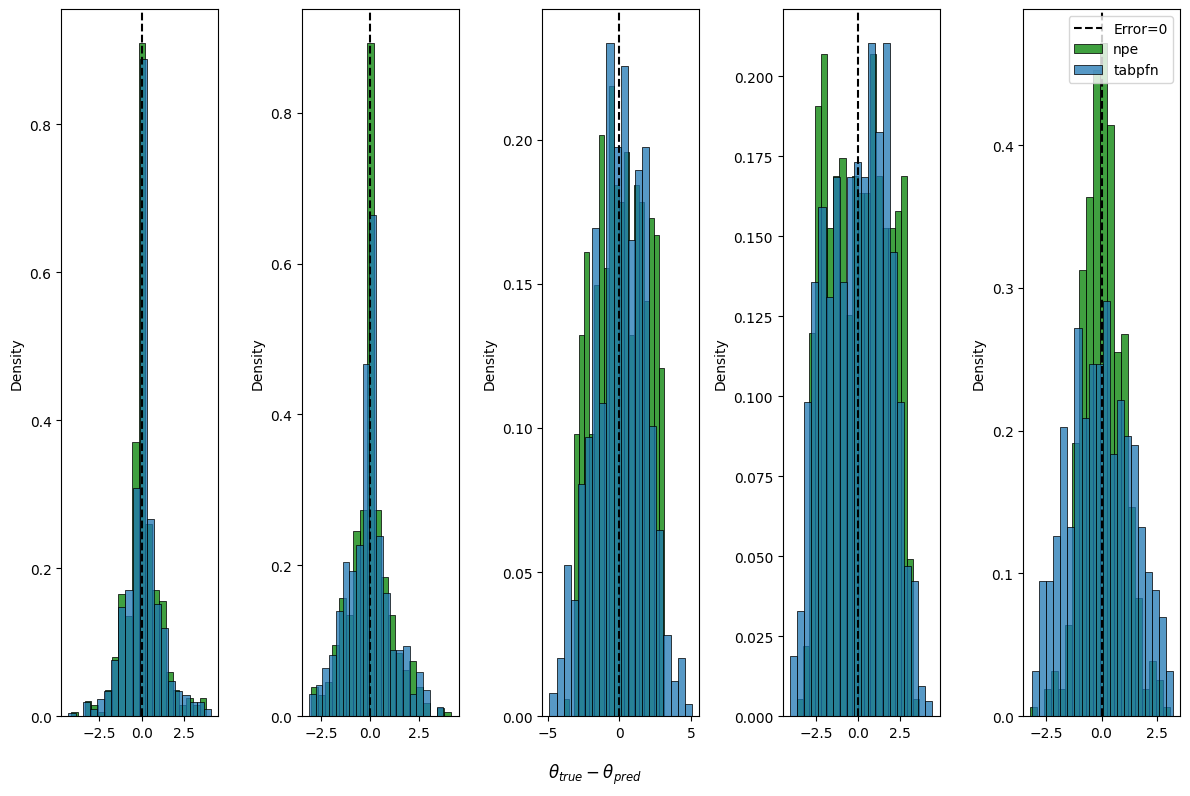

In [15]:
from seaborn import histplot

fig, ax = plt.subplots(1,n_params,figsize=(12,8), tight_layout=True)
fig.supxlabel('$θ_{true} - θ_{pred}$')

for i in range(n_params):
    j = i
    # histplot(acc_cp.iloc[:,i], label='cp', color='red', bins=20, stat='density', ax = ax[j])
    histplot(npe_samples[:,:,i].mean(0)-test_theta[:,i], label='npe', color='green', bins=20, stat='density', ax = ax[j])
    histplot(acc_tabpfn[i], label='tabpfn', bins=20, stat='density', ax = ax[j])
    ax[j].axvline(0, color='k', ls='--', label='Error=0')

plt.legend()


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y0, test_size=0.20, random_state=42)
reg = TabPFNRegressor(random_state=42)
reg.fit(X_train, y_train)
quantiles = [0.025,0.975]
pred_tabpfn_0 = reg.predict(test_X.numpy(), output_type="quantiles", quantiles=quantiles)

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function

In [8]:
pre_covs_tabpfn = (test_theta[:,0].numpy() > pred_tabpfn_0[0]) * (test_theta[:,0].numpy() < pred_tabpfn_0[1])
covs_tab_pfn = pre_covs_tabpfn.mean()

In [9]:
covs_tab_pfn

0.838